In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization, Dropout, SpatialDropout2D
from keras import backend as K
from keras.models import Model
from PIL import Image
from sklearn.neural_network import MLPClassifier

# Set random seeds to ensure the reproducible results
from keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator

In [50]:
# small dataset for testing model in shorter running time
#data_dir = '/Users/zhuangxiaobin/Desktop/COMP309/Project/small_traindata'

# big dataset for training model
data_dir = '/Users/zhuangxiaobin/Desktop/COMP309/Project/traindata'

# the directory to store model
pycharm_dir = '/Users/zhuangxiaobin/PycharmProjects/ImageClassification/'

In [51]:
# use data augmentation to create more instance to train and validate the model
# use split parameter to spilt the data into the training and validation
batch_size=50
# Our original images consist in RGB coefficients in the 0-255, but such values
# would be too high for our model to process (given a typical learning rate),
# so we target values between 0 and 1 instead by scaling with a 1/255.
train_datagen = ImageDataGenerator(validation_split=0.2,
                                 rescale=1./255,
                                 rotation_range=30,
                                 shear_range= 0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

# Normalize the test data images, resize them but don't augment them, to eliminate the
# uncertainty of testing results.
validation_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

# load the data from the training directory and set them to two flows training /validation
train = train_datagen.flow_from_directory(data_dir, target_size=(300,300), shuffle=True,
                                         classes=['cherry', 'strawberry', 'tomato'],
                                          batch_size=batch_size, subset='training')

test = validation_datagen.flow_from_directory(data_dir, target_size=(300,300), shuffle=True,
                                         classes=['cherry', 'strawberry', 'tomato'],
                                              batch_size=batch_size, subset='validation')

Found 3548 images belonging to 3 classes.
Found 886 images belonging to 3 classes.


Build MLP model

In [52]:
def build_MLP_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # helps prevent overfitting
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    #adam = Adam(lr=0.001)
    #sgd = SGD(lr=0.001, momentum=0.5)
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    epoch = model.fit_generator(train, validation_data = test, epochs = 50, verbose = 1)
    return epoch, model

In [53]:
# train the model
epoch, MLP_model = build_MLP_model()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 150, 150, 32)      0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 720000)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 2160003   
Total params: 2,160,899
Trainable params: 2,160,899
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
71/71 [==============================] - 262s 4s/step - loss: 1.3385 - accuracy: 0.4118 - val_loss

In [54]:
# Evaluate the model
def evaluate_model():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('MLP model accuracy and loss')
    ax1.plot(epoch.history['val_accuracy'], 'tab:orange', label='val_acc')
    ax1.plot(epoch.history['accuracy'], 'tab:blue', label='acc')
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylabel('Val_Accuracy')
    ax1.set_xlabel('Number of epoch')

    ax2.plot(epoch.history['val_loss'], 'tab:orange', label='val_loss')
    ax2.plot(epoch.history['loss'], 'tab:blue', label='loss')
    ax2.legend()
    ax2.grid(True)
    ax2.set_ylabel('Val_Loss')
    ax2.set_xlabel('Number of epoch')
    return plt.show()

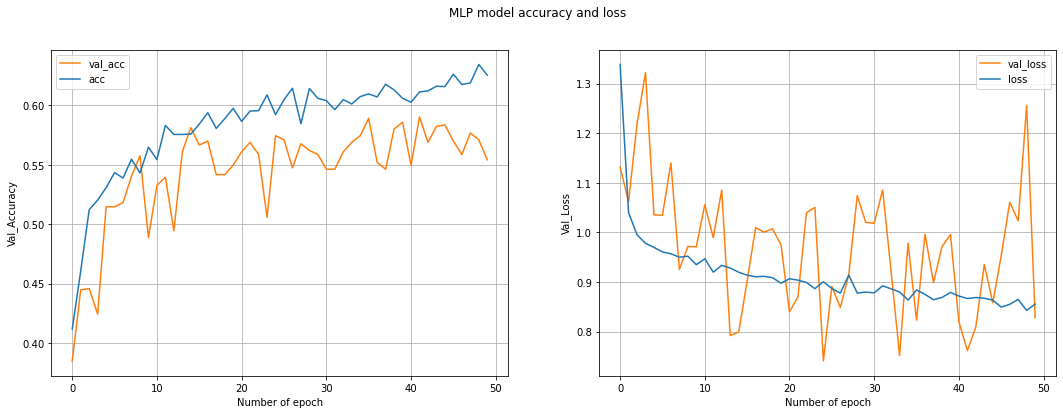

In [55]:
# Evaluate baseline MLP model
evaluate_model()

In [127]:
def save_model(model,name):
    #Save the keras model for later evaluation
    path = pycharm_dir + name + '.h5'
    model.save(path)
    print("Model Saved Successfully.")

In [128]:
#save_model(MLP_model,'model')

Build CNN model

In [ ]:
def build_CNN_base_model():
     model = Sequential()
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))

     model.add(Conv2D(64, (3, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))